# Analysis & Feature Engineering
___

#### Analysis

#### Feature Engineering
* 2.1 Encoding date of each event
* 2.2 Encoding past transaction features
* 2.3 Create last transaction and amount features
* 2.4 Create offer received, viewed and related spending features
* 2.5 Mapping completed and viewed events to offer received row
* 2.6 Calculating days since last transaction
* 2.7 Various feature cleaning
* 2.8 Converting to numerical and NaN
* 2.9 Historical features
* 2.10 Column Ordering and dropping redundant features
* 2.11 Label Encoding categorical features

#### Build Features
* 3.1 Building all features from scratch
* 3.2 Testing build all

## Analysis
___

In order to make a predictive model the data needs to be cleaned and restructered in a tidy format. Each row must be an observation and each column a variable before the data can be fed into a manchine learning algorithm.

Currently the data is structered with each row representing an event.

Event categories are as follows:
* Offer received
* Offer viewed
* Transaction
* Offer completed

Taking a look at the data for the first person/customer:

In [ ]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [ ]:
import numpy as np
import os
import pandas as pd
import joblib
import progressbar
import re
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# importing scripts
%load_ext autoreload
%autoreload 2
%aimport src.data.make_dataset 
%aimport src.utilities.helper
%aimport src.features.build_features

from src.features.build_features import date_features
from src.data.make_dataset import save_file

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [73]:
transcript = joblib.load('../../data/interim/transcript.joblib', mmap_mode=None)
transcript.head(10)

,offer_id,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75.0,100000.0,2017-05-09,1,0,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00,-443,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75.0,100000.0,2017-05-09,1,0,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00,-443,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef01,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75.0,100000.0,2017-05-09,1,0,0,19.89,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.89,-443,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75.0,100000.0,2017-05-09,1,0,0,0.00,g,5.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,19.89,-443,0,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef02,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75.0,100000.0,2017-05-09,1,0,0,17.78,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.67,-443,0,0,0,1
5,78afa995795e4d85b5d9ceeca43f5fefj1,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,75.0,100000.0,2017-05-09,1,0,0,0.00,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,37.67,-443,1,0,0,0
6,78afa995795e4d85b5d9ceeca43f5fefj1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,75.0,100000.0,2017-05-09,1,0,0,0.00,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,37.67,-443,0,1,0,0
7,78afa995795e4d85b5d9ceeca43f5fef03,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,75.0,100000.0,2017-05-09,1,0,0,19.67,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.34,-443,0,0,0,1
8,78afa995795e4d85b5d9ceeca43f5fef04,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,75.0,100000.0,2017-05-09,1,0,0,29.72,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.06,-443,0,0,0,1
9,78afa995795e4d85b5d9ceeca43f5fef05,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,75.0,100000.0,2017-05-09,1,0,0,23.93,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.99,-443,0,0,0,1


In [4]:
def person_data(person):
    '''
    Displays unique customer's event history
    
    Parameters
    -----------
    person: if int then customer index as per the order in which customer appears in transcript data 
    if string then person referenced by their unique 'person' id           
    '''
    
    if type(person) == str:
        return transcript[transcript.person == person]
    return transcript[transcript.person == transcript.person.unique()[person]]

In [5]:
# Displaying event history of person 57 (person='fa7ccb17b2b14f32804d14f86ac87f04')
person_data(57)

,offer_id,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction
1109,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,0,38.0,66000.0,2017-02-11,0,1,0,0.00,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,-530,1,0,0,0
1110,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer viewed,36,38.0,66000.0,2017-02-11,0,1,0,0.00,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,-530,0,1,0,0
1111,fa7ccb17b2b14f32804d14f86ac87f0401,fa7ccb17b2b14f32804d14f86ac87f04,transaction,48,38.0,66000.0,2017-02-11,0,1,0,3.38,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.38,-530,0,0,0,1
1112,fa7ccb17b2b14f32804d14f86ac87f0402,fa7ccb17b2b14f32804d14f86ac87f04,transaction,102,38.0,66000.0,2017-02-11,0,1,0,2.29,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.67,-530,0,0,0,1
1113,fa7ccb17b2b14f32804d14f86ac87f0403,fa7ccb17b2b14f32804d14f86ac87f04,transaction,156,38.0,66000.0,2017-02-11,0,1,0,12.05,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.72,-530,0,0,0,1
1114,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer completed,156,38.0,66000.0,2017-02-11,0,1,0,0.00,e,2.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,17.72,-530,0,0,1,0
1115,fa7ccb17b2b14f32804d14f86ac87f04a1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,168,38.0,66000.0,2017-02-11,0,1,0,0.00,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,17.72,-530,1,0,0,0
1116,fa7ccb17b2b14f32804d14f86ac87f0404,fa7ccb17b2b14f32804d14f86ac87f04,transaction,240,38.0,66000.0,2017-02-11,0,1,0,3.58,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.30,-530,0,0,0,1
1117,fa7ccb17b2b14f32804d14f86ac87f0405,fa7ccb17b2b14f32804d14f86ac87f04,transaction,252,38.0,66000.0,2017-02-11,0,1,0,2.23,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.53,-530,0,0,0,1
1118,fa7ccb17b2b14f32804d14f86ac87f04g1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,408,38.0,66000.0,2017-02-11,0,1,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,23.53,-530,1,0,0,0


Each customer's data comprises of events through time, with time measured in hours.<br>
As a type of time series problem we will extract features based on time.

In [323]:
# Converting time into days
transcript['time_days'] = transcript.time / 24

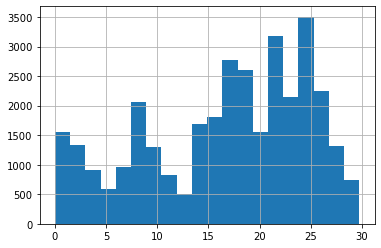

In [7]:
transcript[transcript.event == 'offer completed'].time_days.hist(bins=20);

Time_days range from zero to 30 indicating that for each customer, the period of data coverage is 30 days from sign_up

First sign_up date:  2013-07-29 00:00:00
Last sign_up date:  2018-07-26 00:00:00


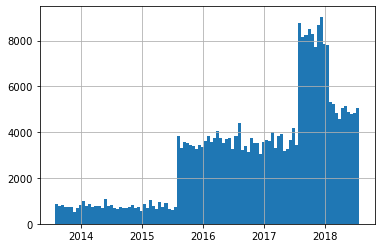

In [12]:
print('First sign_up date: ', transcript.signed_up.min())
print('Last sign_up date: ', transcript.signed_up.max())
transcript.signed_up.hist(bins=100);

Histogram of number of events per year shows an increasing trend with a dip back down in 2018.<br>
Since the histogram has a step shape, this is likely due to the way that the data has been sampled

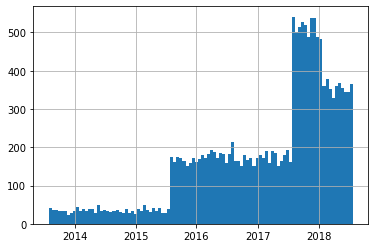

In [278]:
transcript[['person', 'signed_up']].drop_duplicates().signed_up.hist(bins=100);

Comparing this to a histogram of number of customers per year shows a similar pattern. <br> The varying number of transactions per year is therefore mainly driven by number of customers sampled.

In [582]:
def plot_person(person):
    '''
    Plots customer's event history

    Parameters
    -----------
    person: if int then customer index as per the order in which customer appears in transcript data 
    if string then person referenced by their unique 'person' id                
    '''

    for i, event in enumerate(['transaction', 'offer received', 'offer viewed', 'offer completed']):
        # step plot of cumulative transactions
        if event=='transaction':
            x[i] = person_data(person).time_days
            y[i] = person_data(person).cum_amount               
            plt.step(x[i], y[i], alpha=.3, label=event, color='black', where='post')
            
        # scatter plot of events
        else:
            try:
                x[i] = person_data(person)[person_data(person).event==event].time_days
                y[i] = person_data(person)[person_data(person).event==event].cum_amount
                plt.scatter(x[i], y[i], alpha=.7, label=event)
            except:
                pass
            
        # required spending per time for each offer received     
        if event=='offer received':
                      
            received = person_data(person)[person_data(person).event=='offer received'][['time_days', 
                       'difficulty', 'cum_amount', 'duration']].reset_index()
            
            for i in received.index:
                x_diff = [received.iloc[i].time_days, 
                          received.iloc[i].time_days+received.iloc[i].duration]
                y_diff = [received.iloc[i].cum_amount, 
                          received.iloc[i].cum_amount+received.iloc[i].difficulty]
                plt.plot(x_diff, y_diff, color='blue', alpha=.15, linewidth='2')
    
    plt.xlabel('time(days)')
    plt.ylabel('cumulative spend')
    plt.title('Customer event history')
    plt.legend()
    plt.show()

We can visualise any customer's 'journey' over the 30 day period by plotting cumulative transaction spend and offer events <br>
versus time.
* Offers received are indicated by dashed blue lines representing the duration of offer validity (x-axis) vs difficulty (y-axis).
* If the customers cumulative transaction spend curve is above the tail end of an offer received curve, this indicates <br>
that the customer has spent enough during the validity period to complete that particular offer.

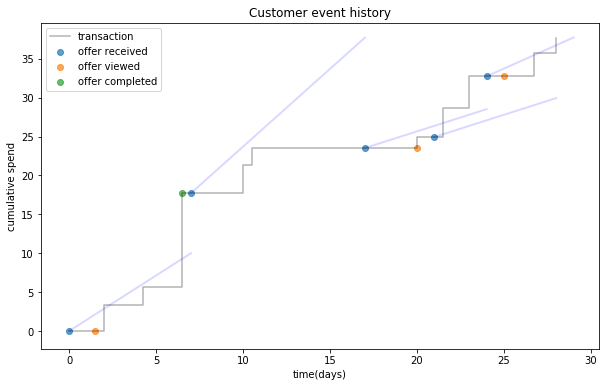

In [583]:
# Plotting customer event history of person 57 (person='fa7ccb17b2b14f32804d14f86ac87f04')
plt.figure(figsize=(10,6))
plot_person(57)

Here we can see in this example that the first offer ('**e**' with difficulty 10 and duration 7) was received at time <br>
zero. By day 6.5, the offer was completed with total spend during the validity period of 17.72.

In the contrast the next three offers were not completed, visually this is seen as the transaction spend falling below <br>
the offer received curves.

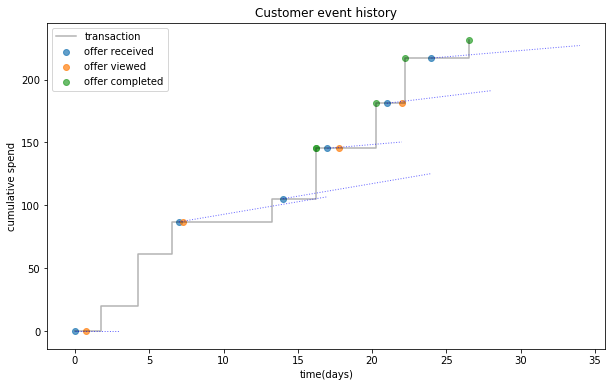

In [575]:
plt.figure(figsize=(10,6))
plot_person(5002)

Since the customer is not aware of an offer until they view it, a key question will be to compare how much is spent <br>
during the period when the customer has knowledge of an offer vs when they do not.

Visually acustomer who is resonsive should have a steeper cumulative transaction spending curve after an offer is viewed vs before.

## 2. Feature Engineering

### 2.1 Encoding date of each event

Creating new column with date of event - This assumes that time 0 is equal to signed up date, which may not be the case.
* Adding day, weekday, month and year features. 
* Will later determine if these features have any predictive power

In [321]:
def date_features(transcript, save=None):
    ''' 
    Create various date/time features
    
    Parameters
    -----------
    transcript: DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim' 
    
    Returns
    -------
    DataFrame of processed data
    '''
            
    transcript['time_days'] = transcript.time / 24
    transcript['date'] = transcript.signed_up + pd.to_timedelta(transcript.time_days, unit='D')
    transcript['day'] = transcript.date.dt.day
    transcript['weekday'] = transcript.date.dt.dayofweek
    transcript['month'] = transcript.date.dt.month
    transcript['year'] = transcript.date.dt.year
    
    save_file(transcript, save) 
    
    return transcript

In [5]:
transcript = date_features(transcript, save='trancript_date_features_22_10.joblib')

saved as ../../data/interim/trancript_date_features_22_10.joblib


### 2.2 Encoding past transaction features
>Hypothesising that the previous spending habits of a customer will help predict their future spending habits. Currently transactions are listed as separate rows and will need to be mapped to one row only. We will take each offer received as an observation and map historical spending before the offer was received to buckets of total spending going back 1, 3, 7, 14, 21 and 30 days in the past. This should capture the effect of trends. The same will be done for the number of transactions since a customer's frequency of purchase may have a different effect to total spending value e.g few large purchases vs many small purchases.

In [12]:
def create_transaction_ranges(transcript, save=None):
    
    '''
    Creates time bucket fields for total transaction value and number of transactions going back in time from the offer received event.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''

    transcript['t_1'] = 0
    transcript['t_3'] = 0
    transcript['t_7'] = 0
    transcript['t_14'] = 0
    transcript['t_21'] = 0
    transcript['t_30'] = 0

    transcript['t_1c'] = 0
    transcript['t_3c'] = 0
    transcript['t_7c'] = 0
    transcript['t_14c'] = 0
    transcript['t_21c'] = 0
    transcript['t_30c'] = 0
    
    transaction_days_range = [30,21,14,7,3,1]  

    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] =='offer received':
            
            # loop backwards through events of customer
            for j in transcript.index[0:i+1][::-1]:
                transaction_amount = transcript.loc[j, 'amount']
                                
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                # if transaction, how many days before offer received?
                if transcript.loc[j, 'event'] == 'transaction':                                       
                    date_diff = transcript.loc[i, 'date'] - transcript.loc[j, 'date']
                    
                    # loop through transaction day ranges and add increment transaction value and
                    # increment transaction count
                    for m in transaction_days_range:
                        transaction_range = 't_' + str(m)
                        transaction_range_count = transaction_range + 'c'
                        
                        if date_diff <= pd.Timedelta(days=m):
                            transcript.loc[i, transaction_range] += transaction_amount
                            transcript.loc[i, transaction_range_count] += 1
                        else:
                            break
    
    save_file(transcript, save)  

    return transcript

In [10]:
transcript = create_transaction_ranges(transcript, save="transcript_transaction_ranges_22_10.joblib")

  4% (12720 of 306534) |                 | Elapsed Time: 0:04:59 ETA:   2:34:31

KeyboardInterrupt: 

### 2.3 Create last transaction and amount features
> Hypthothesising that the last transaction amount before an offer is viewed, and date of last transaction might affect affect liklihood of offer completion.

In [26]:
def last_transaction_and_amount(transcript, save=None):
    '''
    Creates last transaction and last amount spend features.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''
    
    transcript['last_transaction'] = 0 
    transcript['last_amount'] = 0

    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] =='offer received':
            
            # loop backwards through events of customer
            for j in transcript.index[0:i+1][::-1]:

                transaction_amount = transcript.loc[j, 'amount']
    
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break

                if transcript.loc[j, 'event'] == 'transaction':
                    transcript.loc[i, 'last_transaction'] = transcript.loc[j, 'date']
                    transcript.loc[i, 'last_amount'] = transcript.loc[j, 'amount']
                    break
    
    save_file(transcript, save)        

    return transcript

In [28]:
transcript = last_transaction_and_amount(transcript, save='trancript_last_transaction_22_10.joblib')

  0% (1784 of 306534) |                  | Elapsed Time: 0:00:04 ETA:   0:11:27

KeyboardInterrupt: 

#### 2.4 Create offer received, viewed and related spending features

We do not want to target customers that spend the required difficulty amount or a large proportion of it without viewing an offer as this will reduce profit.<br>
We want to target customers that are responsive and will increase spending as soon as an offer is viewed. 

> The following features are created to assess different spending habits when an offer is received and viewed: <br>
>* **received_spend** -  How much has a customer spent towards an offer before viewing it? <br>
* **viewed_spend** - How much spending was made within the validity period after viewing an offer? <br>
* **viewed_days_left** -  How many days left to complete an offer after viewing it? <br>
* **remaining_to_complete** - How much did customer spend after viewing the offer? <br>
* **viewed_in_valid** - Did the customer actually view the offer during the valid period? <br>

In [29]:
def viewed_received_spend(transcript, save=None):
    '''
    Creates received_spend, viewed_spend, viewed_days_left, remaining_to_complete, viewed_in_valid feaures
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''   
    
    transcript['received_spend'] = 0
    transcript['viewed_spend'] = 0
    transcript['viewed_days_left'] = pd.Timedelta(days=-1)
    transcript['remaining_to_complete'] = 0
    transcript['viewed_in_valid'] = 0
   
    bar = progressbar.ProgressBar()

    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] == 'offer received':

            for j in transcript.index[i+1:]:                        
                
                # check if still same person
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                # check if period is within duration
                if transcript.loc[j, 'date'] - transcript.loc[i, 'date'] > pd.Timedelta(days=transcript.loc[i, 'duration']):
                    break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if transcript.loc[j, 'event'] == 'offer viewed':
                    transcript.loc[i, 'viewed_in_valid'] = True
                                        
                    if transcript.loc[i, 'received_spend'] <= transcript.loc[i, 'difficulty']:
                        transcript.loc[i, 'viewed_days_left'] = pd.Timedelta(days=transcript.loc[i, 'duration']) - (transcript.loc[j, 'date'] - transcript.loc[i, 'date'])
                        transcript.loc[i, 'remaining_to_complete'] = transcript.loc[i, 'difficulty'] - transcript.loc[i, 'received_spend'] - transcript.loc[i, 'viewed_spend']
                    else:
                        transcript.loc[i, 'viewed_days_left'] = pd.Timedelta(days=0)
                        transcript.loc[i, 'remaining_to_complete'] = 0
                                
                # for transactions
                if transcript.loc[j, 'event'] == 'transaction':
                    
                    # update spending when received but not viewed                    
                    if transcript.loc[i, 'viewed_days_left'] < pd.Timedelta(days=0):
                        transcript.loc[i, 'received_spend'] += transcript.loc[j, 'amount']
                                           
                    # update spending when viewed
                    if transcript.loc[i, 'viewed_days_left'] >= pd.Timedelta(days=0):
                        transcript.loc[i, 'viewed_spend'] += transcript.loc[j, 'amount']
       
    save_file(transcript, save)       

    return transcript

In [ ]:
transcript = viewed_received_spend(transcript, save='trancript_viewed_received_22_10.joblib')

#### 2.5 Mapping completed and viewed events to offer received row

In [16]:
def match_verification(transcript, event=None):
    '''
    Helper function that validates whether total number of events(offer completed or offer viewed) from raw 
    data matches newly created 'complete' or 'viewed' feature.
    
    Parameters
    -----------
    transcript:  DataFrame
    event: string ('offer received' or 'offer completed')
    '''     
    
    if event == 'offer completed':
        eventid = 'completed'
    if event == 'offer viewed':
        eventid = 'viewed'
    
    raw = transcript[transcript.event == event].groupby('person').id.count()    
    calculated = transcript.groupby('person')[eventid].sum()

    # joining by id to match persons
    comparison_df = pd.DataFrame(calculated).join(raw)
    comparison_df.id.replace(np.nan,0, inplace=True)
    comparison_df[eventid].replace(np.nan,0, inplace=True)

    # Checking that there are no differences between each user
    if (comparison_df.id - comparison_df[eventid]).value_counts()[0.0] == transcript.person.nunique():
        print(event, ' mapped to offer rows correctly')
    else:
        print('some ' + event + 'mapped incorrectly, please compare:')
        display(comparison_df[comparison_df[eventid] - comparison_df.id != 0])

In [16]:
def mapping_event(transcript, event=None, save=None):
    '''
    Maps the events 'offer completed' or 'offer viewed' to the corresponding 'offer received' row of the dataset
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''     
    
    if event == 'offer completed':
        eventid = 'completed'
        event_check = 'already_completed'
    if event == 'offer viewed':
        eventid = 'viewed'
        event_check = 'already_viewed'
       
    transcript[event_check] = 0
    transcript[eventid] = 0
       
    bar = progressbar.ProgressBar()

    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] == 'offer received':

            for j in transcript.index[i+1:]:
                
                if transcript.loc[j, event_check] == 1:
                    continue
                
                # check if still same person
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                # check if period is within duration
                if event == 'offer completed':        
                    if transcript.loc[j, 'date'] - transcript.loc[i, 'date'] > pd.Timedelta(days=transcript.loc[i, 'duration']):
                        break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if transcript.loc[j, 'event'] == event:
                    if transcript.loc[j, 'id'] == transcript.loc[i, 'id']:
                        transcript.loc[j, event_check] = 1
                        transcript.loc[i, eventid] = 1
                        break
       
    match_verification(transcript, event=event)
    transcript.drop([event_check], axis=1, inplace=True)
    save_file(transcript, save)         

    return transcript

#### 2.6 Calculating days since last transaction

In [335]:
def days_since_transaction(transcript, save=None):
    '''
    Calculates number of days since last transaction for each offer received.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''   
    
    transcript['last_transaction_days'] = 0 
    bar = progressbar.ProgressBar()
    for i, j in bar(transcript.iterrows()):
        if j.last_transaction != 0:
            transcript.loc[i, 'last_transaction_days'] = (j.date - j.last_transaction).days      
    
    save_file(transcript, save) 
    return transcript

#### 2.7 Various feature cleaning
* Dropping no longer needed features
* Calculating spending during offer period
* Added calculated completion feature (was more spent in offer period than offer difficulty)
* Filtering by only offer received row and dropping other event rows and columns

In [33]:
def feature_cleanup(transcript, save=None):
    '''
    Various features creation and redundant features dropped.
    
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
       
    # drop cumulative amount since equal to t-30
    transcript.drop(['cum_amount'], axis=1, inplace=True)
    
    # spending during offer period - to be predicted 
    transcript['offer_spend'] = transcript.received_spend + transcript.viewed_spend
    
    # adding boolean target variable to be predicted - was offer completed?
    transcript['spend>required'] = (transcript.received_spend + transcript.viewed_spend > transcript.difficulty).astype(int)
    
    # filtering event by only offer received, data now all included in this row
    transcript = transcript[transcript.event=='offer received']
    
    # dropping original event column
    transcript.drop(['event'], axis=1, inplace=True)
    
    # dropping offer_id since now each row is a unique offer
    transcript.drop(['offer_id'], axis=1, inplace=True)
    
    # dropping joined since same as signed_up
    transcript.drop('joined', axis=1, inplace=True)
    
    # removing 'amount' and 'transaction' since this data related to individual transactions
    transcript.drop(['amount', 'transaction'], axis=1, inplace=True)
    
    
    save_file(transcript, save) 
    return transcript

#### 2.8 Converting to numerical and NaN
* In order to run machine learning algorithm, will need to convert all features to numerical format
* Where a numerical value of zero is not representative. E.g. if there were not any previous transactions this is different from the previous transaction being zero days in the past, these are converted to NaN.
* We will be using the CatBoost classifier which is capable of handling NaN values.

In [34]:
def to_numerical_nan(transcript, save=None):
    '''
    Converts date and other features to numerical in preparation . Where zero values are not correctly descriptive, converts 
    these to NaNs.
        
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
       
    # creating columns converting date time and time deltas to floats
    transcript['signed_up0'] = (transcript.signed_up - transcript.signed_up.max()).dt.days
    transcript['date0'] = (transcript.date - transcript.signed_up.max()).dt.days
    
    # replacing last transaction 0 with NaN since gradient boosting algorithms will be able to differentiate NaNs
    transcript.last_transaction.replace(0, np.nan, inplace=True)
    transcript.last_transaction_days[transcript.last_transaction.isnull()] = np.nan
    transcript.last_transaction = pd.to_datetime(transcript.last_transaction)
    transcript['last_tran'] = (transcript.last_transaction - transcript.signed_up.max()).dt.days
    transcript['last_tran_days'] = transcript.date0 - transcript.last_tran
    
    # replacing old date time and time delta columns with new float versions:
    transcript.signed_up = transcript.signed_up0
    transcript.date = transcript.date0
    transcript.last_transaction = transcript.last_tran
    transcript.last_transaction_days = transcript.last_tran_days

    # dropping interim new columns:
    transcript.drop(['signed_up0', 'date0', 'last_tran', 'last_tran_days'], axis=1, inplace=True)

    # converting viewed_days_left to integers
    transcript.viewed_days_left = transcript.viewed_days_left.dt.days

    # converting viewed_in_valid boolean to integer
    transcript.viewed_in_valid = transcript.viewed_in_valid *1
    
    # converting viewed_in_valid to integer
    transcript.viewed_in_valid = transcript.viewed_in_valid.astype(int)
        
    # replacing zeros with nulls for viewed_days_left and remaining to complete, since this value is only relevent if customer viewed offer
    transcript.viewed_days_left[transcript.viewed_in_valid == 0] = np.nan
    transcript['remaining_to_complete'][transcript.viewed_in_valid == 0] = np.nan
    
    save_file(transcript, save) 
    return transcript

#### 2.9 Historical features
When trying to predict whether a customer given a particular offer at a particular point in time will complete, there are two possibilities. Either we have visibility of the customers previous history or it is a new customer and we do not.
Here we build historical features that try to encapsulate the customers historical offer completion behaviour. The following are historical totals that apply to a customer at a particular point in time.
* Rewards completed
* Rewards offered
* Difficulties completed
* Difficulties offered
* Number of completions
* Number of offers
* Number viewed and completed
* Number completed but not viewed
* Number of offers not completed
* Number of offers viewed
* Total spending during offer durations
* Total spending during offer periods with offer viewed


We will need to ascertain if these features add predictive power to a model

In [64]:
def historical_features(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    transcript['hist_reward_completed'] = 0 
    transcript['hist_reward_possible'] = 0 
    transcript['hist_difficulty_completed'] = 0 
    transcript['hist_difficulty_possible'] = 0 
    transcript['hist_previous_completed'] = 0 
    transcript['hist_previous_offers'] = 0
    transcript['hist_viewed_and_completed'] = 0 
    transcript['hist_complete_not_viewed'] = 0 
    transcript['hist_failed_complete'] = 0
    transcript['hist_viewed'] = 0
    transcript['hist_received_spend'] = 0
    transcript['hist_viewed_spend'] = 0
    
    transcript.reset_index(inplace=True, drop=True)                          
    bar = progressbar.ProgressBar()
    
    
    for i in bar(transcript.index):
        for j in transcript.index[0:i][::-1]:
            
            # if different customer, break
            if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                break            
            
            # looping through previous offers, if completed, make additions to total features:
            if transcript.loc[j, 'completed'] == 1: 
                transcript.loc[i, 'hist_reward_completed'] += transcript.loc[j, 'reward']
                transcript.loc[i, 'hist_reward_possible'] += transcript.loc[j, 'reward']
                transcript.loc[i, 'hist_difficulty_completed'] += transcript.loc[j, 'difficulty']
                transcript.loc[i, 'hist_difficulty_possible'] += transcript.loc[j, 'difficulty']
                transcript.loc[i, 'hist_previous_completed'] += 1
                transcript.loc[i, 'hist_previous_offers'] += 1
                
                # if viewed, make additions to view features:
                if transcript.loc[j, 'viewed'] == 1: 
                    transcript.loc[i, 'hist_viewed_and_completed'] += 1
                else:
                    transcript.loc[i, 'hist_complete_not_viewed'] += 1
            
            # if didn't complete offer, make additions to possible features:                                        
            else:
                transcript.loc[i, 'hist_reward_possible'] += transcript.loc[j, 'reward']
                transcript.loc[i, 'hist_difficulty_possible'] += transcript.loc[j, 'difficulty']
                transcript.loc[i, 'hist_previous_offers'] += 1
                transcript.loc[i, 'hist_failed_complete'] += 1 
            
            # if viewed, make addition to viewed
            if transcript.loc[j, 'viewed'] == 1:
                transcript.loc[i, 'hist_viewed'] += 1
            
            # increment viewed and received spend
            transcript.loc[i, 'hist_received_spend'] += transcript.loc[j, 'received_spend']
            transcript.loc[i, 'hist_viewed_spend'] += transcript.loc[j, 'viewed_spend']
            
    save_file(transcript, save)       
    return transcript

In [26]:
transcript = create_time_buckets_offer_received(transcript, save=None)

100% (76277 of 76277) |##################| Elapsed Time: 0:00:07 Time:  0:00:07


#### 2.10 Column Ordering and dropping redundant features

In [ ]:
def column_order(transcript, save=None):
    '''
    Removing redundant features and moving target features 'offer_spend' and 'completed'
    to last columns.
        
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
    
    transcript = transcript[['person', 'age', 'income', 'signed_up', 'gender', 'id',
                'rewarded', 'difficulty', 'reward', 'duration', 'mobile', 'web',
                'social', 'bogo', 'discount', 'informational', 'time_days', 'day',
                'weekday', 'month', 'year', 't_1', 't_3', 't_7', 't_14', 't_21', 't_30',
                't_1c', 't_3c', 't_7c', 't_14c', 't_21c', 't_30c', 'last_amount', 'received_spend', 
                'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 
                'viewed', 'last_transaction_days', 'spend>required',
                'hist_reward_completed', 'hist_reward_possible',
                'hist_difficulty_completed', 'hist_difficulty_possible',
                'hist_previous_completed', 'hist_previous_offers',
                'hist_viewed_and_completed', 'hist_complete_not_viewed',df
                'hist_failed_complete', 'hist_viewed', 'hist_received_spend',
                'hist_viewed_spend','offer_spend', 'completed']]
    
    save_file(transcript, save)
    return transcript

#### 2.11 Label Encoding categorical features
* Since the CatBoost gradient boosting algorithm that we utilise is able to handle categorical features, we should not have these one hot encoding.

In [132]:
def label_encode_categories(transcript, save=None):
    '''
    Label encodes gender and id, removing previous created one hot encoding.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
           
    Returns
    -------
    DataFrame
    '''
    le = LabelEncoder()
    transcript.id = le.fit_transform(transcript.id)
    le.fit_transform(transcript.id)
    transcript['gender'] = transcript[['F', 'M', 'O']].idxmax(1)
    transcript.gender = le.fit_transform(transcript.gender)
    transcript = transcript.drop(['F', 'M', 'O'], axis=1)
    
    save_file(transcript, save)
    return transcript

## 3. Build all features

In [125]:
def build_all_features(transcript, save=None, all=True):
    '''
    Runs all feature engineering functions returning processed dataframe
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
    all: Bool (default=True)
        If true saves a time stamped version of the file after each function is run.
            
    Returns
    -------
    DataFrame
    '''   
    
    def save_str(save):
        if all == True:
            saving = re.split('[./]', save)[-2] +'_' + datetime.datetime.now().strftime('%m-%d_%H_%M_%S') + '.joblib'
        else: 
            saving = None
        return saving
       
    transcript = src.features.build_features.date_features(transcript, save=save_str(save))
    print('> date features added')

    transcript = src.features.build_features.create_transaction_ranges(transcript, save=save_str(save))
    print('> transaction ranges added')

    transcript = src.features.build_features.last_transaction_and_amount(transcript, save=save_str(save))

    transcript = src.features.build_features.viewed_received_spend(transcript, save=save_str(save))
    print('> view received spending added')    
    
    transcript = src.features.build_features.mapping_event(transcript, event='offer viewed', save=save_str(save))
    print('> mapped offer viewed')
    
    transcript = src.features.build_features.mapping_event(transcript, event='offer completed', save=save_str(save))
    print('> mapped offer completed')

    transcript = src.features.build_features.days_since_transaction(transcript, save=save_str(save))
    print('> added last transaction days')
    
    transcript = src.features.build_features.feature_cleanup(transcript, save=save_str(save))
    print('> cleaned features')
   
    transcript = src.features.build_features.to_numerical_nan(transcript, save=save_str(save))
    print('> converted to numerical')
    
    transcript = src.features.build_features.historical_features(transcript, save=save_str(save))
    print('> historical features added')
    
    transcript = src.features.build_features.label_encode_categories(transcript,save=save_str(save))
    print('categorical variables encoded')
        
    transcript = src.features.build_features.column_order(transcript, save=save_str(save))
    print('columns reordered')
    
    return transcript

#### 3.1 Building all features from scratch

In [88]:
transcript = joblib.load('../../data/interim/transcript.joblib', mmap_mode=None)
transcript = build_all_features(transcript, save='transcript_final.joblib', all=True)

N/A% (0 of 306534) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--

saved as ../../data/interim/transcript_final_10-24_15_54_47.joblib
> date features added


  0% (291 of 306534) |                   | Elapsed Time: 0:00:06 ETA:   2:09:06

KeyboardInterrupt: 

In [122]:
transcript = joblib.load('../../data/interim/final.joblib')

In [130]:
transcript = joblib.dump(transcript, '../../data/interim/transcript_final.joblib', compress=True)

#### 3.2 Testing build all

In [129]:
def test_build():
    '''
    Tests build_all_features with the first 1057 rows of transcript.    
    '''
    transcript = joblib.load('../../data/interim/transcript.joblib', mmap_mode=None)
    test = transcript.iloc[0:1057].copy()
    test = build_all_features(test, all=False)
    return test

test = test_build()
test.head(10)

  3% (41 of 1057) |                      | Elapsed Time: 0:00:00 ETA:   0:00:03

> date features added


100% (1057 of 1057) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
 34% (362 of 1057) |#######              | Elapsed Time: 0:00:00 ETA:   0:00:00

> transaction ranges added


100% (1057 of 1057) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1057 of 1057) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 36% (389 of 1057) |#######              | Elapsed Time: 0:00:00 ETA:   0:00:00

> view received spending added


100% (1057 of 1057) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (482 of 1057) |#########            | Elapsed Time: 0:00:00 ETA:   0:00:00

offer viewed  mapped to offer rows correctly
> mapped offer viewed


100% (1057 of 1057) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
- | #                                               | 448 Elapsed Time: 0:00:00

offer completed  mapped to offer rows correctly
> mapped offer completed


| |  #                                             | 1056 Elapsed Time: 0:00:00
../..\src\features\build_features.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript['signed_up0'] = (transcript.signed_up - transcript.signed_up.max()).dt.days
../..\src\features\build_features.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript['date0'] = (transcript.date - transcript.signed_up.max()).dt.days
../..\src\features\build_features.py:374: SettingWithCopyWarning: 
A value is trying to be set

> added last transaction days
> cleaned features
> converted to numerical


100% (247 of 247) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
../..\src\features\build_features.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript['gender'] = transcript[['F', 'M', 'O']].idxmax(1)


> historical features added
categorical variables encoded
columns reordered


,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,date,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_transaction,last_amount,received_spend,viewed_spend,viewed_days_left,remaining_to_complete,viewed_in_valid,viewed,last_transaction_days,spend>required,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,offer_spend,completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-430,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-430,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,NaN,0.00,0.00,37.67,6.0,5.00,1,1,NaN,1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-430,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,-423,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1,2,2,2,2,2,-424.0,17.78,0.00,49.39,1.0,0.00,1,1,1.0,1,5.0,5.0,5.0,5.0,1,1,1,0,0,1,0.00,37.67,49.39,0
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-430,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,-413,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0,1,2,5,5,5,-415.0,23.93,0.00,48.28,7.0,10.00,1,1,2.0,1,5.0,5.0,5.0,5.0,1,2,1,0,1,2,0.00,87.06,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-430,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,-409,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0,0,1,3,5,5,-415.0,23.93,48.28,0.00,0.0,0.00,1,1,6.0,1,15.0,15.0,15.0,15.0,2,3,2,0,1,3,0.00,135.34,48.28,1
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-343,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-343,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,NaN,0.00,0.00,1.09,9.0,20.00,1,1,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,1.09,0
5,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-343,0,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,14.0,-329,18,4,8,2017,0.00,3.50,4.59,4.59,4.59,4.59,0,1,2,2,2,2,-332.0,3.50,0.00,0.00,4.0,0.00,1,1,3.0,0,0.0,5.0,0.0,20.0,0,1,0,0,1,1,0.00,1.09,0.00,0
6,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-343,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,17.0,-326,21,0,8,2017,0.00,0.00,3.50,4.59,4.59,4.59,0,0,1,2,2,2,-332.0,3.50,0.00,0.00,NaN,NaN,0,0,6.0,0,0.0,5.0,0.0,20.0,0,2,0,0,2,2,0.00,1.09,0.00,0
7,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-343,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,21.0,-322,25,4,8,2017,0.00,0.00,0.00,4.59,4.59,4.59,0,0,0,2,2,2,-332.0,3.50,0.06,0.00,5.0,19.94,1,1,10.0,0,0.0,5.0,0.0,20.0,0,3,0,0,3,2,0.00,1.09,0.06,0
8,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-343,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,24.0,-319,28,0,8,2017,0.00,0.00,0.00,3.50,4.59,4.59,0,0,0,1,2,2,-332.0,3.50,0.06,0.00,8.0,19.94,1,0,13.0,0,0.0,10.0,0.0,40.0,0,4,0,0,4,3,0.06,1.09,0.06,0
9,e2127556f4f64592b11af22de27a7932,68.0,70000.0,-78,1,4,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-78,26,3,4,2018,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,NaN,0.00,0.00,0.00,6.0,10.00,1,1,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,0.00,0


# ------------------------------ Old notes, keep incase for now ----------------------------

### Initial analysis
Using XGboost, initial tests are achieving very poor results trying to predict completion not knowing whether a customer has viewed an offer or not.

Currently am using test data as different customers as well as in the future - so this is harder to predict

Previous testing was based on having a boolean of viewed or not included in training data, plus excluding NaNs from dataset

In [ ]:
# Best results so far:
boost = XGBClassifier(max_depth=10, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)

Very poor positive classification with only 225 out of 611 positive recall 

In [ ]:
confusion_matrix(y_test, preds_boost)

array([[13674,  4870],
       [  386,   225]], dtype=int64)

#### Analysis - separating data into different groupings

In [ ]:
# Completed total
print('completed and viewed: ', tranj[(tranj.viewed_in_valid > 0) & (tranj.complete >0)].shape[0], '<-- good')
print('completed didnt view: ', tranj[(tranj.viewed_in_valid == 0) & (tranj.complete >0)].shape[0], '<-- bad')
print('completed_total:      ', tranj[(tranj.complete >0)].shape[0])
print('viewed total:         ', tranj[(tranj.viewed_in_valid > 0)].shape[0])
print('Didnt view/complete:  ', tranj[(tranj.viewed_in_valid == 0) & (tranj.complete == 0)].shape[0])
print()
print('received_spend:       ', tranj.received_spend.sum())
print('viewed_spend:         ', tranj.viewed_spend.sum())
print('offer_spend:          ', tranj.offer_spend.sum())

completed and viewed:  40312 <-- good
completed didnt view:  5466 <-- bad
completed_total:       45778
viewed total:          62987
Didnt view/complete:   7824

received_spend:        391680.92
viewed_spend:          1695482.32
offer_spend:           2087163.24


In [ ]:
tranj[~tranj.id.isin(['i','j'])].complete.sum()

36295

In [ ]:
total_compelted = 33579

In [ ]:
36295-33576

2719

In [ ]:
tranj_completed = tranj[~tranj.id.isin(['i','j'])].groupby('person').complete.sum()

In [ ]:
tranj_completes = tranj_completed[tranj_completed>0]

In [ ]:
tranc_completes = tranc[tranc.event=="offer completed"].groupby('person').offer_id.count()

In [ ]:
tranc_completes

person
0009655768c64bdeb2e877511632db8f    3
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    3
0020ccbbb6d84e358d3414a3ff76cffd    3
003d66b6608740288d6cc97a6903f4f0    3
                                   ..
fff29fb549084123bd046dbc5ceb4faa    6
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    3
fffad4f4828548d1b5583907f2e9906b    3
ffff82501cea40309d5fdd7edcca4a07    6
Name: offer_id, Length: 12774, dtype: int64

In [ ]:
tranj_completes

person
0009655768c64bdeb2e877511632db8f    3
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    3
0020ccbbb6d84e358d3414a3ff76cffd    3
003d66b6608740288d6cc97a6903f4f0    3
                                   ..
fff29fb549084123bd046dbc5ceb4faa    6
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    4
fffad4f4828548d1b5583907f2e9906b    3
ffff82501cea40309d5fdd7edcca4a07    6
Name: complete, Length: 13456, dtype: int32

In [ ]:
tranc_completes.shape[0] - tranj_completes.shape[0]

-682

In [ ]:
# Completed total
print('completed and viewed: ', tranf[(tranf.viewed_in_valid > 0) & (tranf.complete >0)].shape[0], '<-- good')
print('completed didnt view: ', tranf[(tranf.viewed_in_valid == 0) & (tranf.complete >0)].shape[0], '<-- bad')
print('completed_total:      ', tranf[(tranf.complete >0)].shape[0])
print('viewed total:         ', tranf[(tranf.viewed_in_valid > 0)].shape[0])
print('Didnt view/complete:  ', tranf[(tranf.viewed_in_valid == 0) & (tranf.complete == 0)].shape[0])
print()
print('received_spend:       ', tranf.received_spend.sum())
print('viewed_spend:         ', tranf.viewed_spend.sum())
print('offer_spend:          ', tranf.offer_spend.sum())

completed and viewed:  1950 <-- good
completed didnt view:  2703 <-- bad
completed_total:       4653
viewed total:          17671
Didnt view/complete:   55903

received_spend:        69177.44
viewed_spend:          41253.950000000004
offer_spend:           110431.38999999998


In [ ]:
# Completed total
print('completed and viewed: ', tranj[(tranj.viewed_in_valid > 0) & (tranj.completed >0)].shape[0], '<-- good')
print('completed didnt view: ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed >0)].shape[0], '<-- bad')
print('completed_total:      ', tranj[(tranj.completed >0)].shape[0])
print('viewed total:         ', tranj[(tranj.viewed_in_valid > 0)].shape[0])
print('Didnt view/completed:  ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed == 0)].shape[0])
print()
print('received_spend:       ', tranj.received_spend.sum())
print('viewed_spend:         ', tranj.viewed_spend.sum())
print('offer_spend:          ', tranj.offer_spend.sum())

completed and viewed:  30664 <-- good
completed didnt view:  2915 <-- bad
completed_total:       33579
viewed total:          62987
Didnt view/completed:   10375

received_spend:        391680.92
viewed_spend:          1695482.32
offer_spend:           2087163.24


In [ ]:
# Completed total
print('completed and viewed: ', tranj[(tranj.viewed_in_valid > 0) & (tranj.completed >0)].shape[0], '<-- good')
print('completed didnt view: ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed >0)].shape[0], '<-- bad')
print('completed_total:      ', tranj[(tranj.completed >0)].shape[0])
print('viewed total:         ', tranj[(tranj.viewed_in_valid > 0)].shape[0])
print('Didnt view/completed:  ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed == 0)].shape[0])
print()
print('received_spend:       ', tranj.received_spend.sum())
print('viewed_spend:         ', tranj.viewed_spend.sum())
print('offer_spend:          ', tranj.offer_spend.sum())

completed and viewed:  30664 <-- good
completed didnt view:  2915 <-- bad
completed_total:       33579
viewed total:          62987
Didnt view/completed:   10375

received_spend:        391680.92
viewed_spend:          1695482.32
offer_spend:           2087163.24


In [ ]:
tranb[tranb.event == 'offer viewed'].shape

(57725, 53)

In [ ]:
new_test = pd.DataFrame(tranj_completes).join(tranc_completes).head(100)

In [ ]:
new_test.head(10)

,complete,offer_id
person,,
0009655768c64bdeb2e877511632db8f,3,3.0
0011e0d4e6b944f998e987f904e8c1e5,3,3.0
0020c2b971eb4e9188eac86d93036a77,3,3.0
0020ccbbb6d84e358d3414a3ff76cffd,3,3.0
003d66b6608740288d6cc97a6903f4f0,3,3.0
00426fe3ffde4c6b9cb9ad6d077a13ea,1,1.0
004b041fbfe44859945daa2c7f79ee64,2,2.0
004c5799adbf42868b9cff0396190900,5,5.0
005500a7188546ff8a767329a2f7c76a,2,1.0


In [ ]:
new_test['diff'] = new_test.complete - new_test.offer_id

In [ ]:
new_test

,complete,offer_id,diff
person,,,
0009655768c64bdeb2e877511632db8f,3,3.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,3,3.0,0.0
0020c2b971eb4e9188eac86d93036a77,3,3.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,0.0
003d66b6608740288d6cc97a6903f4f0,3,3.0,0.0
00426fe3ffde4c6b9cb9ad6d077a13ea,1,1.0,0.0
004b041fbfe44859945daa2c7f79ee64,2,2.0,0.0
004c5799adbf42868b9cff0396190900,5,5.0,0.0
005500a7188546ff8a767329a2f7c76a,2,1.0,1.0


In [ ]:
tranc = tranc[['offer_id', 'person', 'event', 'time', 'time_days', 'age', 'income', 'signed_up',
       'F', 'M', 'O', 'amount', 'id', 'rewarded', 'difficulty', 'reward',
       'duration', 'mobile', 'web', 'social', 'bogo', 'discount',
       'informational', 'cum_amount', 'joined', 'offer received',
       'offer viewed', 'offer completed', 'transaction', 'date',
       'day', 'weekday', 'month', 'year']]

In [ ]:
tranc[tranc.person == Extras.loc[0,0]]

,offer_id,person,event,time,time_days,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction,date,day,weekday,month,year
209383,008d7088107b468893889da0ede0df5ch1,008d7088107b468893889da0ede0df5c,offer received,0,0.00,24.0,42000.0,2017-09-10,0,1,0,0.00,h,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00,-319,1,0,0,0,2017-09-10 00:00:00,10,6,9,2017
209384,008d7088107b468893889da0ede0df5ch1,008d7088107b468893889da0ede0df5c,offer viewed,18,0.75,24.0,42000.0,2017-09-10,0,1,0,0.00,h,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00,-319,0,1,0,0,2017-09-10 18:00:00,10,6,9,2017
209385,008d7088107b468893889da0ede0df5c01,008d7088107b468893889da0ede0df5c,transaction,108,4.50,24.0,42000.0,2017-09-10,0,1,0,3.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,-319,0,0,0,1,2017-09-14 12:00:00,14,3,9,2017
209386,008d7088107b468893889da0ede0df5c02,008d7088107b468893889da0ede0df5c,transaction,120,5.00,24.0,42000.0,2017-09-10,0,1,0,2.72,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.72,-319,0,0,0,1,2017-09-15 00:00:00,15,4,9,2017
209387,008d7088107b468893889da0ede0df5c03,008d7088107b468893889da0ede0df5c,transaction,132,5.50,24.0,42000.0,2017-09-10,0,1,0,0.23,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.95,-319,0,0,0,1,2017-09-15 12:00:00,15,4,9,2017
209388,008d7088107b468893889da0ede0df5ce1,008d7088107b468893889da0ede0df5c,offer received,168,7.00,24.0,42000.0,2017-09-10,0,1,0,0.00,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,5.95,-319,1,0,0,0,2017-09-17 00:00:00,17,6,9,2017
209389,008d7088107b468893889da0ede0df5c04,008d7088107b468893889da0ede0df5c,transaction,192,8.00,24.0,42000.0,2017-09-10,0,1,0,1.06,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.01,-319,0,0,0,1,2017-09-18 00:00:00,18,0,9,2017
209390,008d7088107b468893889da0ede0df5c05,008d7088107b468893889da0ede0df5c,transaction,228,9.50,24.0,42000.0,2017-09-10,0,1,0,4.07,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.08,-319,0,0,0,1,2017-09-19 12:00:00,19,1,9,2017
209391,008d7088107b468893889da0ede0df5cj1,008d7088107b468893889da0ede0df5c,offer received,336,14.00,24.0,42000.0,2017-09-10,0,1,0,0.00,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,11.08,-319,1,0,0,0,2017-09-24 00:00:00,24,6,9,2017
209392,008d7088107b468893889da0ede0df5cj1,008d7088107b468893889da0ede0df5c,offer viewed,396,16.50,24.0,42000.0,2017-09-10,0,1,0,0.00,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,11.08,-319,0,1,0,0,2017-09-26 12:00:00,26,1,9,2017


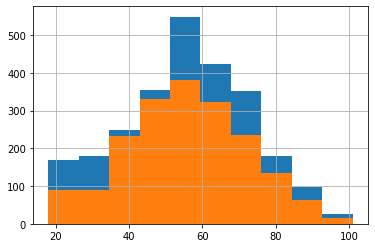

In [ ]:
#completed didnt view vs completed did view - shows little difference
tranf[(tranf.viewed_in_valid == 0) & (tranf.complete >0)].age.hist()
tranf[(tranf.viewed_in_valid > 0) & (tranf.complete >0)].age.hist()

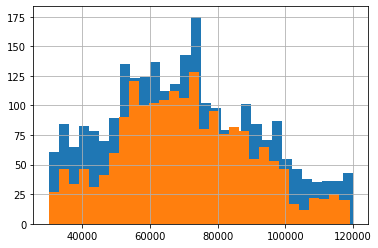

In [ ]:
#completed didnt view vs completed did view - shows little difference
tranf[(tranf.viewed_in_valid == 0) & (tranf.complete >0)].income.hist(bins=30)
tranf[(tranf.viewed_in_valid > 0) & (tranf.complete >0)].income.hist(bins=30)

In [ ]:
tranf.viewed_spend.sum()

41253.950000000004

In [ ]:
def train_test_by_time(df):
    '''
    Splits dataframe into 75% train and 25% test by signed_up date.
    Test data is taken from the 25% newest offers, this comprises a different customer base to the train set and requries prediction of the future.    
    '''
        
    test_data = df[df.signed_up >= df.signed_up.quantile(q=.75)]
    train_data = df[df.signed_up < df.signed_up.quantile(q=.75)]
    
    X_train = train_data.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 'offer_spend'], axis=1)
    y_train = X_train.complete
    X_train = X_train.drop('complete', axis=1)

    X_test = test_data.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 'offer_spend'], axis=1)
    y_test = X_test.complete
    X_test = X_test.drop('complete', axis=1)
    
    print('X_train', X_train.shape, round(X_train.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('X_test', X_test.shape, round(X_test.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('y_train', y_train.shape)
    print('y_test', y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_by_time(tranf)

X_train (57122, 47) 0.7489
X_test (19155, 47) 0.2511
y_train (57122,)
y_test (19155,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from xgboost.sklearn import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
minmax = MinMaxScaler()
X_train_scale = minmax.fit_transform(X_train)
X_test_scale = minmax.fit_transform(X_test)

### Testing without splitting by time and customer

In [ ]:
X = tranf.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 'offer_spend', 'complete'], axis=1)

In [ ]:
y = tranf.complete

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
X_train_scale = minmax.fit_transform(X_train)
X_test_scale = minmax.fit_transform(X_test)

In [ ]:
boost = XGBClassifier(max_depth=10, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)

In [ ]:
confusion_matrix(y_test, preds_boost)

array([[9214, 8660],
       [ 318,  878]], dtype=int64)

In [ ]:
boost = XGBClassifier(max_depth=10, scale_pos_weight=50).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

array([[12049,  5825],
       [  486,   710]], dtype=int64)

In [ ]:
boost = XGBClassifier(max_depth=10, scale_pos_weight=20).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

array([[14616,  3258],
       [  742,   454]], dtype=int64)

In [ ]:
boost = XGBClassifier(max_depth=20, scale_pos_weight=50).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

array([[17569,   305],
       [ 1153,    43]], dtype=int64)

In [ ]:
boost = XGBClassifier(max_depth=20, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

array([[16565,  1309],
       [ 1031,   165]], dtype=int64)

### Testing out of only viewed:

In [ ]:
tran_viewed = tranf[tranf.viewed_in_valid > 0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_by_time(tran_viewed)

X_train (13222, 47) 0.7482
X_test (4449, 47) 0.2518
y_train (13222,)
y_test (4449,)


In [ ]:
minmax = MinMaxScaler()
X_train_scale = minmax.fit_transform(X_train)
X_test_scale = minmax.fit_transform(X_test)

In [ ]:
# Best results so far:
boost = XGBClassifier(max_depth=10, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)

In [ ]:
y_test.sum()

190

In [ ]:
confusion_matrix(y_test, preds_boost)

array([[2988, 1271],
       [ 120,   70]], dtype=int64)

### Adding features for when offer is viewed:

In [ ]:
def row_complete(offer_transaction, save=None):
    
'''
Loops forward, calculates future spending - these are more target variables

Y variable - Spending:
* received but not viewed
* viwewed and received

When viewed:
* how many days left to complete
* how much spending needed to complete
* simple boolean was viewed when valid?
'''    
    
    offer_transaction['received_spend'] = 0
    offer_transaction['viewed_spend'] = 0
    offer_transaction['viewed_days_left'] = pd.Timedelta(days=-1)
    offer_transaction['remaining_to_complete'] = 0
    offer_transaction['viewed_in_valid'] = 0
   
    bar = progressbar.ProgressBar()

    for i in bar(offer_transaction.index):
        if offer_transaction.loc[i, 'event'] == 'offer received':

            for j in offer_transaction.index[i+1:]:
                
                
                
                # check if still same person
                if offer_transaction.loc[j, 'person'] != offer_transaction.loc[i, 'person']:
                    break
                
                # check if period is within duration
                if offer_transaction.loc[j, 'date'] - offer_transaction.loc[i, 'date'] > pd.Timedelta(days=offer_transaction.loc[i, 'duration']):
                    break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if offer_transaction.loc[j, 'event'] == 'offer viewed':
                    offer_transaction.loc[i, 'viewed_in_valid'] = True
                    
                    
                    if offer_transaction.loc[i, 'received_spend'] <= offer_transaction.loc[i, 'difficulty']:
                                            
                        offer_transaction.loc[i, 'viewed_days_left'] = pd.Timedelta(days=offer_transaction.loc[i, 'duration']) - (offer_transaction.loc[j, 'date'] - offer_transaction.loc[i, 'date'])
                        offer_transaction.loc[i, 'remaining_to_complete'] = offer_transaction.loc[i, 'difficulty'] - offer_transaction.loc[i, 'received_spend'] - offer_transaction.loc[i, 'viewed_spend']
                
                    else:
                        offer_transaction.loc[i, 'viewed_days_left'] = pd.Timedelta(days=0)
                        offer_transaction.loc[i, 'remaining_to_complete'] = 0
                
                
                # for transactions
                if offer_transaction.loc[j, 'event'] == 'transaction':
                    
                    # update spending when received but not viewed                    
                    if offer_transaction.loc[i, 'viewed_days_left'] < pd.Timedelta(days=0):
                        offer_transaction.loc[i, 'received_spend'] += offer_transaction.loc[j, 'amount']
                                           
                    # update spending when viewed

                    if offer_transaction.loc[i, 'viewed_days_left'] >= pd.Timedelta(days=0):
                        offer_transaction.loc[i, 'viewed_spend'] += offer_transaction.loc[j, 'amount']
                            
    if save:
        try:
            dirName='../../data/interim'
            os.mkdir(dirName)
            print("Directory " , dirName ,  " Created ") 
        except FileExistsError:
            pass

        tranc.to_pickle(dirName + '/viewed_received_spend_test.pickle')
        print('saved as {}'.format(dirName + '/viewed_received_spend_test.pickle'))        

    return tranc

### Mini Analysis of spending with offers - Rough

In [ ]:
# Total spend during recevied but not viewed period
tranc.received_spend.sum()

69177.44

In [ ]:
tranc.amount.sum()

1775451.9700000002

In [ ]:
# Percentage spend during received but now viwed time vs total spend
tranc.received_spend.sum() / tranc.amount.sum()

0.03896328437428808

In [ ]:
# Percentage spend during viewed and still valid vs total spend
tranc.viewed_spend.sum() / tranc.amount.sum()

0.06219902980535148

Since percentage spend once viewed is higher we can see that viewing an offer within the validity period does make an increase in spend rate

### Features to add

Label encoding?
* check which is better for xgboost - doesn't increase dimensionality

Recent activity:

* Last purchase date
* Last offer view date


Historical offer give:
* which year offer was give (1-3)?
* which month offer was given (1-12)
* which dat of month was give (1-31)
* which day of week offer give (1-7)


Spending history by value - encodes trendlines:
* Total life-time
* Last year
* Last month
* last two weeks
* last week
* Spend on weekends
* Closeness to major events - e.g. 3 days before holidays. e.g. national holidays, sporting events, weekends, first saturday of month etc.


Experimental:
<body>
    <p>
    <a href="https://www.slideshare.net/HJvanVeen/feature-engineering-72376750">* Feature Engineering slideshow</a><br>
    <a href="https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b">* Continuous Numeric Data</a>
    </p>
</body>

Mean encoding?

* **Count encoding** - replace categorical variables with their count in the training set, also log transform could be good
* **Label count encoding** - rank categorical variables by their count in training set
* **Target encoding** - Encode categorical variables by their ratio of target - MUST BE CAFEFUL TO NOT OVERFIT - check page 15
> need to cross-validate, also add random noise to avoid overfitting. When applied properly best encoding for linear and non-linear
<br> This is a form of stacking that outputs the average target
<br> THis would be like encoding average spend for particular succesful offers in category
* **Interactions** - Specifically encodes the interactions between numerical variables. E.g. subtraction, multiplication, division.
Check feature selection by statistical tests, trained model feature importances.



___

* **NaN encoding** - use of explicit encoding for NaNs instead of ignoring
* **Category Embeddings** - use of neural networks to create dense embeddings - the characteristics of offers are already kind of like this
* **Polynomial encoding** - will increase number of features a lot

___
Not really applicable
* **Expansion encoding** - expand out long string of information into separate categories
* **Consolidation encoding** - Mapping similar data e.g. mistakes to same variable
* **Rounding** - form of lossy compression - sometimes too much precision is noise
* **Binning** ?


___
Discard features that risk overfitting